In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision
import tqdm
import matplotlib.pyplot as plt
import torch.distributions as dist
import abc

from torch.utils.data import DataLoader
from torch.distributions.distribution import Distribution

from priors import *
from models import *



In [4]:
# only run this cell if you use weights and biases for logging
import wandb

wandb.init(project = "BNN_VI", 
            config = {"learning_rate": 0.001,
                      "batch_size": 128,
                      "epochs": 10,
                      "hidden_size": 100,
                      "Temperature": 0.1,})


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jorgefernando17. Use `wandb login --relogin` to force relogin


In [5]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
x_train = torch.from_numpy(trainset.data.numpy().reshape(-1, 28*28))/255.
y_train = torch.from_numpy(trainset.targets.numpy())
train_data = torch.utils.data.TensorDataset(x_train, y_train)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
x_test = torch.from_numpy(testset.data.numpy().reshape(-1, 28*28))/255.
y_test = torch.from_numpy(testset.targets.numpy())
test_data = torch.utils.data.TensorDataset(x_test, y_test)


train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


5


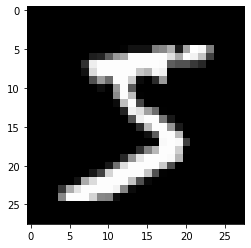

In [6]:
feature = trainset[0][0]
label = trainset[0][1]
print(label)
plt.imshow(feature.squeeze(), cmap='gray')
plt.show()


In [7]:
# set the Temperature
Temperature_posterior = 0.1

# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_dim = 28*28, output_dim = 10, hidden_dims = [100], Temperature = Temperature_posterior)
print(model)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.99)

# train the model
epochs = 10
num_samples = 5

for epoch in tqdm.tqdm(range(epochs)):
    num_batches = len(train_loader)
    for i, (x, y) in enumerate(train_loader):
        # zero the gradients
        optimizer.zero_grad()

        # reshape the data
        x = x.view(-1, 28*28)

        # reset loss
        loss = torch.tensor(0.0)

        # forward pass
        for e in range(num_samples):
            output, kl_divergence = model(x)
            loss += (F.nll_loss(F.softmax(output, dim = 1), y, reduction = "sum") + kl_divergence/num_batches)/num_samples

        # backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # accuracy
        acc = torch.mean((torch.argmax(F.softmax(output, dim = 1), dim = 1) == y).float())

        # print the loss
        if i % 100 == 0:
            print(f"Epoch: {epoch} | Batch: {i} | Loss: {loss.item()}, accuracy: {acc.item()}")
            scheduler.step()
            wandb.log({"loss": loss.item(), "accuracy": acc.item(), "epoch": epoch, "batch": i})
            wandb.log({"learning_rate": scheduler.get_lr()[0]})
           
        

  0%|          | 0/10 [00:00<?, ?it/s]

Bayesian_Neural_Network(
  (layers): ModuleList(
    (0): Linear_Layer(
      (weight_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weight_posterior): MultivariateDiagonalGaussian()
      (bias_posterior): MultivariateDiagonalGaussian()
    )
    (1): Linear_Layer(
      (weight_prior): MultivariateDiagonalGaussian()
      (bias_prior): MultivariateDiagonalGaussian()
      (weight_posterior): MultivariateDiagonalGaussian()
      (bias_posterior): MultivariateDiagonalGaussian()
    )
  )
  (activation): ReLU(inplace=True)
)
Epoch: 0 | Batch: 0 | Loss: -25.382606506347656, accuracy: 0.140625


c:\Users\jorge\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 0 | Batch: 100 | Loss: -21.55978775024414, accuracy: 0.0625
Epoch: 0 | Batch: 200 | Loss: -21.210094451904297, accuracy: 0.09375
Epoch: 0 | Batch: 300 | Loss: -21.245655059814453, accuracy: 0.015625
Epoch: 0 | Batch: 400 | Loss: -22.652477264404297, accuracy: 0.109375
Epoch: 0 | Batch: 500 | Loss: -22.17298126220703, accuracy: 0.0625
Epoch: 0 | Batch: 600 | Loss: -24.517311096191406, accuracy: 0.1875
Epoch: 0 | Batch: 700 | Loss: -26.467578887939453, accuracy: 0.125
Epoch: 0 | Batch: 800 | Loss: -26.19237518310547, accuracy: 0.15625
Epoch: 0 | Batch: 900 | Loss: -23.932968139648438, accuracy: 0.078125


 10%|█         | 1/10 [00:41<06:14, 41.64s/it]

Epoch: 1 | Batch: 0 | Loss: -24.243560791015625, accuracy: 0.1875
Epoch: 1 | Batch: 100 | Loss: -21.299623489379883, accuracy: 0.140625
Epoch: 1 | Batch: 200 | Loss: -29.035717010498047, accuracy: 0.171875
Epoch: 1 | Batch: 300 | Loss: -29.197616577148438, accuracy: 0.21875
Epoch: 1 | Batch: 400 | Loss: -29.193588256835938, accuracy: 0.140625
Epoch: 1 | Batch: 500 | Loss: -32.4738883972168, accuracy: 0.125
Epoch: 1 | Batch: 600 | Loss: -31.402193069458008, accuracy: 0.171875
Epoch: 1 | Batch: 700 | Loss: -37.98482894897461, accuracy: 0.359375
Epoch: 1 | Batch: 800 | Loss: -37.002681732177734, accuracy: 0.3125
Epoch: 1 | Batch: 900 | Loss: -38.53569793701172, accuracy: 0.4375


 20%|██        | 2/10 [01:20<05:26, 40.85s/it]

Epoch: 2 | Batch: 0 | Loss: -37.6713981628418, accuracy: 0.359375
Epoch: 2 | Batch: 100 | Loss: -43.17170715332031, accuracy: 0.46875
Epoch: 2 | Batch: 200 | Loss: -43.524288177490234, accuracy: 0.53125
Epoch: 2 | Batch: 300 | Loss: -40.8895263671875, accuracy: 0.375
Epoch: 2 | Batch: 400 | Loss: -39.900753021240234, accuracy: 0.46875
Epoch: 2 | Batch: 500 | Loss: -46.13690185546875, accuracy: 0.5
Epoch: 2 | Batch: 600 | Loss: -49.978206634521484, accuracy: 0.578125
Epoch: 2 | Batch: 700 | Loss: -40.635986328125, accuracy: 0.40625
Epoch: 2 | Batch: 800 | Loss: -48.31614685058594, accuracy: 0.53125
Epoch: 2 | Batch: 900 | Loss: -42.888587951660156, accuracy: 0.46875


 30%|███       | 3/10 [02:00<04:44, 40.67s/it]

Epoch: 3 | Batch: 0 | Loss: -48.995201110839844, accuracy: 0.484375
Epoch: 3 | Batch: 100 | Loss: -53.36888885498047, accuracy: 0.625
Epoch: 3 | Batch: 200 | Loss: -56.194541931152344, accuracy: 0.640625
Epoch: 3 | Batch: 300 | Loss: -51.26356887817383, accuracy: 0.59375
Epoch: 3 | Batch: 400 | Loss: -46.07379150390625, accuracy: 0.484375
Epoch: 3 | Batch: 500 | Loss: -44.501434326171875, accuracy: 0.453125
Epoch: 3 | Batch: 600 | Loss: -45.62287139892578, accuracy: 0.5
Epoch: 3 | Batch: 700 | Loss: -58.85750198364258, accuracy: 0.671875
Epoch: 3 | Batch: 800 | Loss: -54.37439727783203, accuracy: 0.609375
Epoch: 3 | Batch: 900 | Loss: -52.68785858154297, accuracy: 0.609375


 40%|████      | 4/10 [02:38<03:58, 39.78s/it]

Epoch: 4 | Batch: 0 | Loss: -58.72350311279297, accuracy: 0.671875
Epoch: 4 | Batch: 100 | Loss: -52.705413818359375, accuracy: 0.5625
Epoch: 4 | Batch: 200 | Loss: -52.418357849121094, accuracy: 0.609375
Epoch: 4 | Batch: 300 | Loss: -53.747581481933594, accuracy: 0.59375
Epoch: 4 | Batch: 400 | Loss: -48.403072357177734, accuracy: 0.5625
Epoch: 4 | Batch: 500 | Loss: -54.819129943847656, accuracy: 0.640625
Epoch: 4 | Batch: 600 | Loss: -53.06112289428711, accuracy: 0.609375
Epoch: 4 | Batch: 700 | Loss: -55.926429748535156, accuracy: 0.609375
Epoch: 4 | Batch: 800 | Loss: -54.02983093261719, accuracy: 0.65625
Epoch: 4 | Batch: 900 | Loss: -51.80818176269531, accuracy: 0.546875


 50%|█████     | 5/10 [03:18<03:18, 39.69s/it]

Epoch: 5 | Batch: 0 | Loss: -50.37287902832031, accuracy: 0.578125
Epoch: 5 | Batch: 100 | Loss: -58.88292694091797, accuracy: 0.625
Epoch: 5 | Batch: 200 | Loss: -56.5912971496582, accuracy: 0.65625
Epoch: 5 | Batch: 300 | Loss: -50.92012405395508, accuracy: 0.609375
Epoch: 5 | Batch: 400 | Loss: -51.806861877441406, accuracy: 0.5625
Epoch: 5 | Batch: 500 | Loss: -54.850521087646484, accuracy: 0.65625
Epoch: 5 | Batch: 600 | Loss: -61.243804931640625, accuracy: 0.6875
Epoch: 5 | Batch: 700 | Loss: -52.564476013183594, accuracy: 0.53125
Epoch: 5 | Batch: 800 | Loss: -55.667236328125, accuracy: 0.65625
Epoch: 5 | Batch: 900 | Loss: -60.8765869140625, accuracy: 0.640625


 60%|██████    | 6/10 [04:01<02:42, 40.67s/it]

Epoch: 6 | Batch: 0 | Loss: -59.18873596191406, accuracy: 0.671875
Epoch: 6 | Batch: 100 | Loss: -59.77996063232422, accuracy: 0.6875
Epoch: 6 | Batch: 200 | Loss: -59.14929962158203, accuracy: 0.65625
Epoch: 6 | Batch: 300 | Loss: -62.266510009765625, accuracy: 0.796875
Epoch: 6 | Batch: 400 | Loss: -56.89664840698242, accuracy: 0.703125
Epoch: 6 | Batch: 500 | Loss: -57.36995315551758, accuracy: 0.65625
Epoch: 6 | Batch: 600 | Loss: -60.80188751220703, accuracy: 0.71875
Epoch: 6 | Batch: 700 | Loss: -58.33777618408203, accuracy: 0.609375
Epoch: 6 | Batch: 800 | Loss: -63.98553466796875, accuracy: 0.75
Epoch: 6 | Batch: 900 | Loss: -63.7171745300293, accuracy: 0.78125


 70%|███████   | 7/10 [04:44<02:04, 41.47s/it]

Epoch: 7 | Batch: 0 | Loss: -59.75841522216797, accuracy: 0.703125
Epoch: 7 | Batch: 100 | Loss: -59.42042541503906, accuracy: 0.65625
Epoch: 7 | Batch: 200 | Loss: -57.62932205200195, accuracy: 0.640625
Epoch: 7 | Batch: 300 | Loss: -64.47404479980469, accuracy: 0.6875
Epoch: 7 | Batch: 400 | Loss: -57.81060028076172, accuracy: 0.546875
Epoch: 7 | Batch: 500 | Loss: -57.986228942871094, accuracy: 0.59375
Epoch: 7 | Batch: 600 | Loss: -57.34613800048828, accuracy: 0.640625
Epoch: 7 | Batch: 700 | Loss: -69.29993438720703, accuracy: 0.84375
Epoch: 7 | Batch: 800 | Loss: -58.797203063964844, accuracy: 0.703125
Epoch: 7 | Batch: 900 | Loss: -64.32237243652344, accuracy: 0.8125


 80%|████████  | 8/10 [05:26<01:23, 41.71s/it]

Epoch: 8 | Batch: 0 | Loss: -60.922264099121094, accuracy: 0.703125
Epoch: 8 | Batch: 100 | Loss: -60.906368255615234, accuracy: 0.734375
Epoch: 8 | Batch: 200 | Loss: -65.03965759277344, accuracy: 0.8125
Epoch: 8 | Batch: 300 | Loss: -63.88807678222656, accuracy: 0.78125
Epoch: 8 | Batch: 400 | Loss: -59.067100524902344, accuracy: 0.703125
Epoch: 8 | Batch: 500 | Loss: -65.09175872802734, accuracy: 0.765625
Epoch: 8 | Batch: 600 | Loss: -67.79367065429688, accuracy: 0.828125
Epoch: 8 | Batch: 700 | Loss: -66.2960205078125, accuracy: 0.78125
Epoch: 8 | Batch: 800 | Loss: -65.63008880615234, accuracy: 0.75
Epoch: 8 | Batch: 900 | Loss: -63.79781723022461, accuracy: 0.78125


 90%|█████████ | 9/10 [06:04<00:40, 40.55s/it]

Epoch: 9 | Batch: 0 | Loss: -65.17582702636719, accuracy: 0.75
Epoch: 9 | Batch: 100 | Loss: -66.12711334228516, accuracy: 0.75
Epoch: 9 | Batch: 200 | Loss: -65.3927230834961, accuracy: 0.8125
Epoch: 9 | Batch: 300 | Loss: -60.99403381347656, accuracy: 0.71875
Epoch: 9 | Batch: 400 | Loss: -64.03375244140625, accuracy: 0.765625
Epoch: 9 | Batch: 500 | Loss: -67.22047424316406, accuracy: 0.84375
Epoch: 9 | Batch: 600 | Loss: -62.90800857543945, accuracy: 0.765625
Epoch: 9 | Batch: 700 | Loss: -62.14739990234375, accuracy: 0.75
Epoch: 9 | Batch: 800 | Loss: -62.72443771362305, accuracy: 0.734375
Epoch: 9 | Batch: 900 | Loss: -67.0567398071289, accuracy: 0.828125


100%|██████████| 10/10 [06:44<00:00, 40.41s/it]


In [8]:
# predict class probabilities for the test data
predicted_probs = model.predict_probs(x_test, 100)
predicted_class = torch.argmax(predicted_probs, axis = 1)

accuracy = torch.sum(predicted_class == y_test) / len(y_test)
print(f"Accuracy: {accuracy}")

print(torch.hstack((torch.tensor(predicted_class).unsqueeze(1), torch.tensor(y_test).unsqueeze(1))))

Accuracy: 0.8289999961853027
tensor([[7, 7],
        [2, 2],
        [1, 1],
        ...,
        [4, 4],
        [8, 5],
        [6, 6]])


<ipython-input-8-b9e61f8612f3>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.hstack((torch.tensor(predicted_class).unsqueeze(1), torch.tensor(y_test).unsqueeze(1))))


In [9]:
def ece(predicted_probabilities: np.ndarray, labels: np.ndarray, n_bins: int = 30) -> float:
    """
    Computes the Expected Calibration Error (ECE).
    Many options are possible; in this implementation, we provide a simple version.
    Using a uniform binning scheme on the full range of probabilities, zero
    to one, we bin the probabilities of the predicted label only (ignoring
    all other probabilities). For the ith bin, we compute the avg predicted
    probability, p_i, and the bin's total accuracy, a_i.
    We then compute the ith calibration error of the bin, |p_i - a_i|.
    The final returned value is the weighted average of calibration errors of each bin.
    :param predicted_probabilities: Predicted probabilities, float array of shape (num_samples, num_classes)
    :param labels: True labels, int tensor of shape (num_samples,) with each entry in {0, ..., num_classes - 1}
    :param n_bins: Number of bins for histogram binning
    :return: ECE score as a float
    """
    num_samples, num_classes = predicted_probabilities.shape

    # Predictions are the classes with highest probability
    predictions = np.argmax(predicted_probabilities, axis=1)
    prediction_confidences = predicted_probabilities[range(num_samples), predictions]

    # Use uniform bins on the range of probabilities, i.e. closed interval [0.,1.]
    bin_upper_edges = np.histogram_bin_edges([], bins=n_bins, range=(0., 1.))
    bin_upper_edges = bin_upper_edges[1:]  # bin_upper_edges[0] = 0.

    probs_as_bin_num = np.digitize(prediction_confidences, bin_upper_edges)
    sums_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins, weights=prediction_confidences)
    sums_per_bin = sums_per_bin.astype(np.float32)

    total_per_bin = np.bincount(probs_as_bin_num, minlength=n_bins) \
        + np.finfo(sums_per_bin.dtype).eps  # division by zero
    avg_prob_per_bin = sums_per_bin / total_per_bin

    onehot_labels = np.eye(num_classes)[labels]
    accuracies = onehot_labels[range(num_samples), predictions]  # accuracies[i] is 0 or 1
    accuracies_per_bin = np.bincount(probs_as_bin_num, weights=accuracies, minlength=n_bins) / total_per_bin

    prob_of_being_in_a_bin = total_per_bin / float(num_samples)

    ece_ret = np.abs(accuracies_per_bin - avg_prob_per_bin) * prob_of_being_in_a_bin
    ece_ret = np.sum(ece_ret)
    return float(ece_ret)

In [10]:
wandb.finish()

accuracy,▂▁▁▂▂▂▂▄▄▅▅▄▅▆▅▆▇▆▆▆▆▆▆▆▇█▇▇▆▇▆▇▇██▇▇▇▇█
batch,▁▃▅▆▁▃▅▆▁▃▅▆▁▃▅▇▁▃▅▇▁▃▅▇▁▃▆▇▂▃▆▇▂▃▆▇▂▃▆█
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
learning_rate,██▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
loss,▇██▇█▇▆▅▆▅▄▅▄▃▅▃▂▃▃▃▄▄▃▃▂▂▂▂▂▁▃▂▂▂▁▁▁▂▂▁
accuracy,0.82812
batch,900
epoch,9
learning_rate,0.00181
loss,-67.05674
